# Local Control

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from importlib import reload
import visualise_speed as vs
reload(vs)

from celluloid import Camera
from IPython.display import clear_output
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import warnings
import os
warnings.filterwarnings('ignore')


### Performance with ~constant speed
#### Setup:
* I did 5 runs with speed bound to between 0.4 and 0.6. This speed interval is easy and controlling the speed is not an issue.
* I ran the runs to about 10000 steps and most of the time the car learns to drive by then. Could be run longer to show stronger convergence and more runs for less variance.
* The control loop runs at 20 Hz. So 10k steps is about 8 minutes. The previous reasults with the remote control have been running at 10 Hz.
* Maximum episode length is 1000 steps.
* Reward 1 per step so max reward 1000 per episode
* I augment the data by adding also a mirror version of each sample to the data.

#### Obervations
* Introducing mirror images to the data removes bias for turning left when driving counter clockwise. This helps to generalize to driving in the other direction.
* However, this can hinder the results in the training task.
-> Anecdote: I have a really adversarial oven that looks like the track. Without the augmentation there is such a strong bias to turning inside the track that the car never consider approaching the oven. However, with the augmentation the car would like to explore the oven which can be seen in the data as a lot of terminated runs at around 300 steps.
* The car is able to learn in about 20 to 40 training episodes.
* Completing 1 lap is significantly faster with local control than with remote control and is usually achieved with less than 3 minutes of driving or 3000 steps. However, after this it takes a while to get past the adversarial oven.

#### Ways to improve sample efficiency and reduce required training:
- Remove mirroring data augmentation 
-> Introduces bias which to turning in one direction, does not generalize to both directions
- Reduce polling speed 
-> Probably does not help with wall clock training time, just abosolute samples
- Questionable singe arguably a generalizable model is better

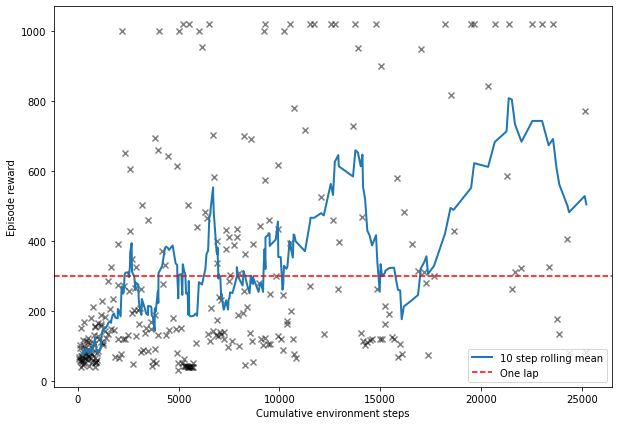

In [3]:
files = sorted(os.listdir("../records/local_control/"))
runs = files[-5:]

total = []

plt.figure(1, (10, 7))
for r in runs:
    data = vs.load_data(f"../records/local_control/{r}")
    episode_lengths = data.groupby("Episode").max().Step
    cum_env_steps = data.groupby("Episode").max().Step.cumsum()
    total += zip(cum_env_steps, episode_lengths)
    plt.scatter(cum_env_steps, episode_lengths, color="k", marker="x", alpha=0.5)
    
total.sort(key=lambda x: x[0])
           
all_cum_steps = [x[0] for x in total]
all_episode_lengths = [x[1] for x in total]
           
step_rewards = pd.DataFrame(data={"steps": all_cum_steps, "reward": all_episode_lengths})

plt.plot(step_rewards.steps, step_rewards.reward.rolling(10).mean(), linewidth=2, label="10 step rolling mean")
plt.axhline(300, linestyle="--", color="r", label="One lap")

plt.xlabel("Cumulative environment steps")
plt.ylabel("Episode reward")
plt.legend()
plt.show()

## Performance with high top speed and bechmark to imitation learning
* I also trained a RL model with a higher top speed 1 m/s that is close to the maximum performance of the car on this track.
* Training takes significantly longer. The episode that I am comparing here is the 63rd of the run and has the best performance. The performance is close to optimal but the policy is not yet converged.
* Training is more difficult since with the max throttle the car easily drives off the track.
* PID controller values affect a lot how the car is able to control the throttle when using higher speeds. More on that later.

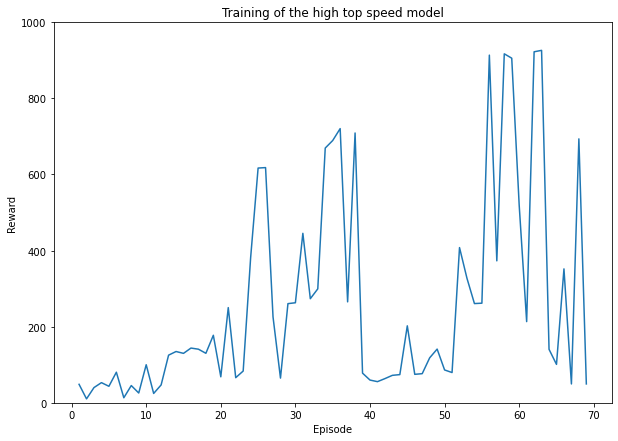

In [4]:
data = vs.load_data("../records/local_control/record_2020-10-11T15:30:24.620797.csv")
plt.figure(1, (10, 7))
plt.title("Training of the high top speed model")
plt.plot(data.groupby("Episode").sum().Speed)
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.ylim(0, 1000)
#plt.axvline(63, linestyle="--", color= "red", label="Example episode")
#plt.legend()
plt.savefig("./plots/Training_speed.pdf")

### Comparison with imitation learning
Below can be seen the trajectories of about 6 laps with imitation and reinforcement learning models as well as the speeds at different points around the track.

The imitation learning model was trained with 10k images taken around the track and uses a categorical model. When testing the trained model I controlled the throttle myself. I was not sure how comparable the batteries were during training and evaluating since this was an older model. An accurate throttle control with the imitation learning model requires comparable battery conditions so I think that this setup is more trutful. **This imitation learning performance is close to the absolute fastest the car can drive around the track.** In the end can be seen that as the speed is pushed higher, the car drives off.

The reinforcement learning result is the best perfoming training episode of a single training run.

* During steady driving the reinforcement learning model has the average speed of 0.94 (m/s) and the imitation learning model has 1.02. Pretty close.
* Imitation learning model has a much more consistent trajectory compared to the RL agent.
* The speed of the RL agent varies more. RL agent controls the throttle itself and through a PID controller so the comparison here is not entirely fair for the RL agent.

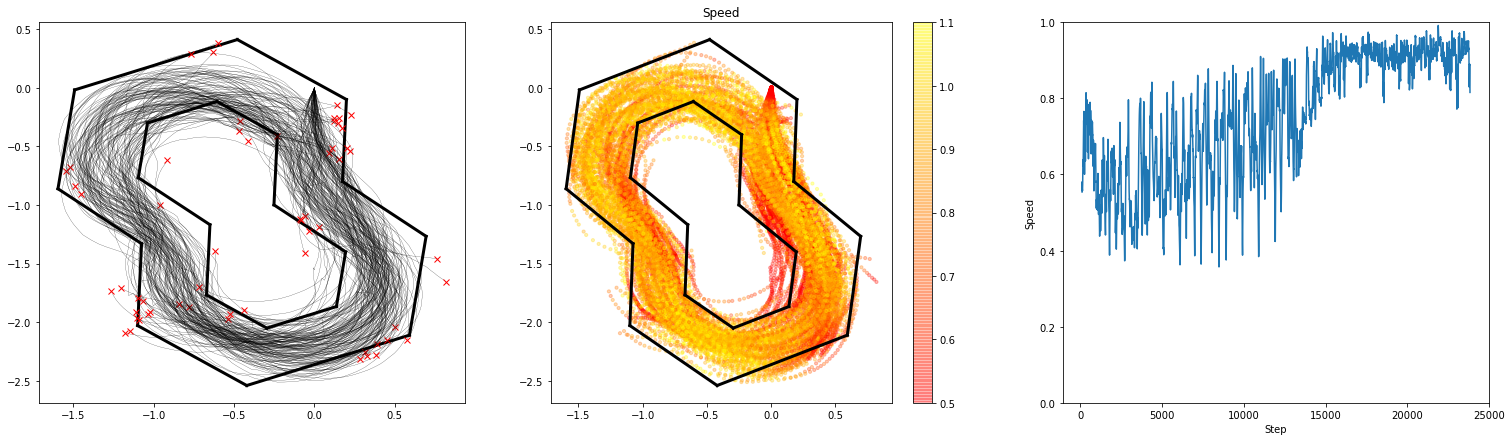

Average speed: 0.71


In [51]:
def plot_lines(x, y, lines):
    angle = 0
    for (angle_diff, length) in lines:
        angle += angle_diff
        endx = x + length * np.cos(np.radians(angle)) 
        endy = y + length * np.sin(np.radians(angle))
        plt.plot([x, endx], [y, endy], color='k', linewidth=3)
        x, y = endx, endy

def plot_tracks():
    l1, l2, l3 = 1.1, 0.70, 0.85
    l1_, l2_, l3_ = 0.47, 0.60, 0.47
    a1, a2, a3 = 60, 55, 50

    track = [
        (-92, l2, l2_),
        (a3,  l2, l2_),
        (-a2, l3,  l1_),
        (-a1, l1,  l1_),
        (-a1, l3,  l1_),
        (-a2, l2,  l2_),
        (a3,  l2, l2_),
        (-a2, l3, l1_),
        (-a1, l1,  l1_),
        (-a1, l3,  l1_)
    ]

    plot_lines(0.2, -0.1, [(a, l) for (a, l, _) in track])
    plot_lines(-0.23, -0.4, [(a, l) for (a, _, l) in track])  

def plot_episode(e, title):
    plt.figure(1, (26, 7))
    plt.subplot(1, 3, 1)
    plot_tracks()
    #plt.title(title, size=16)
    episodes = set(e.Episode)
    for ep in episodes:
        ep_data = e[e.Episode == ep]
        plt.plot(ep_data.PosX, ep_data.PosZ, color = "k", linewidth=0.2)
        if len(ep_data) < 1000:
            plt.plot(ep_data.PosX.values[-1], ep_data.PosZ.values[-1], marker="x", color="r")
    plt.subplot(1, 3, 2)
    plot_tracks()
    plt.scatter(e.PosX, e.PosZ, c=e.Speed, cmap=plt.cm.autumn, s=10, alpha=0.3)
    plt.colorbar()
    plt.clim(0.5, 1.1)
    plt.title("Speed")
    plt.subplot(1, 3, 3)
    plt.ylabel("Speed")
    plt.xlabel("Step")
    plt.plot(np.arange(len(e)), e.Speed.rolling(100).mean())
    plt.ylim(0, 1)
    plt.show()
    print(f"Average speed: {e.Speed.values[200:800].mean():.2f}")

    
data = vs.load_data("../records/local_control/record_2020-10-11T15:30:24.620797.csv")
e_rl = data[(data.Step > 20)]

#data = vs.load_data("../records/local_control/imitation_record_2020-10-11T20:33:52.630958.csv")
#e_im = data[-1100:-200]

#data = vs.load_data("./results/human_baseline.csv")
#e_hu = data[5000:5500]

plot_episode(e_rl, "Reinforcement learning")
#plot_episode(e_im, "Imitation learning")
#plot_episode(e_hu, "Human baseline")

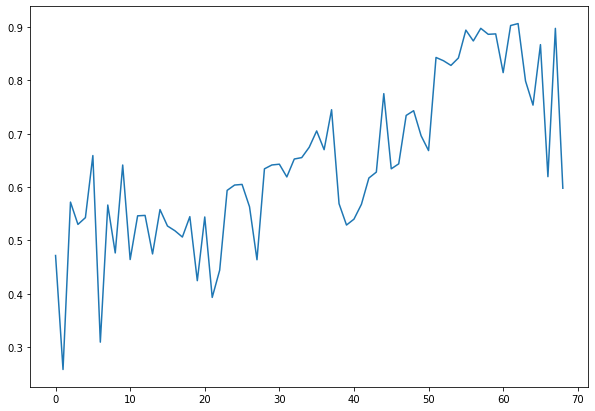

In [25]:
data = vs.load_data("../records/local_control/record_2020-10-11T15:30:24.620797.csv")
speed = data.groupby("Episode").mean().Speed
plt.figure(1, (10, 7))
plt.plot(np.arange(len(speed)), speed)
plt.ylable(spe)
plt.show()

### Controlling throttle with RL + PID + RealSense at higher speeds

When controlling the speed of the car one would desire a really crisp relationship between the output of the neural network and the actual speed of the car. This way the realtionship between the speed output and the actual behavior of the car would be as easy as possible to learn for he agent.

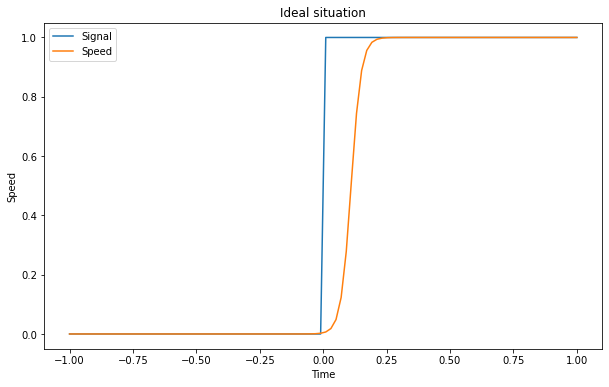

In [5]:
x = np.linspace(-1, 1, 100)
signal = x > 0
speed = 1 / (1 + np.exp(-(x-0.11) * 50))
plt.figure(1, (10, 6))
plt.title("Ideal situation")
plt.plot(x, signal, label="Signal")
plt.plot(x, speed, label="Speed")
plt.xlabel("Time")
plt.ylabel("Speed")
plt.legend()
plt.show()

This however this requires careful tuning of the PID parameters. Currently I am not too happy with the parameters I have. That describes different parts of controlling the speed of the car. 
* Target speed is the speed outputted by the neural network
* This is fed to a PID controller that based on the speed of the car from RealSense adjusts the throttle to match speed and target speed
* The adjusted throttle is then fed to the motor

With smaller speeds and intervals the adjusting is easier. However, with larger speeds and wider intervals the adjusting becomes more challenging. PID parameters govern how the well the cars's speed matches the target speed of the neural network.
* Adjusting the speed quickyl and accurately is pretty difficult.

I am currently not too happy with my PID parameters and have been playing with them quite a bit. Below are some plots how I am doing currently.
* The first plots are from episode 25 when the car is not that sure how to drive and constantly speeds up and slows down. It is clear that in big adjustments the throttle is adjusted incorrecly and the true speed of the car under or overshoots after the adjustment.
* In the latter plots is episode 63 when the car drives with a more constant throttle so it is easier to mathc for the PID. Still, in big adjustments the speed overshoots.

One major thing in this is that a good set of parameters would guarantee a similar response across all battery levels. With a more full battery the response is more crisp than with an emptier barttery. Once my battery ran out during a run and when I swithched it out to a new one the car no longer could control it's speed since the true speed of the car did not respond to the target speed similarly to before. With the new battery the car drove too fast.

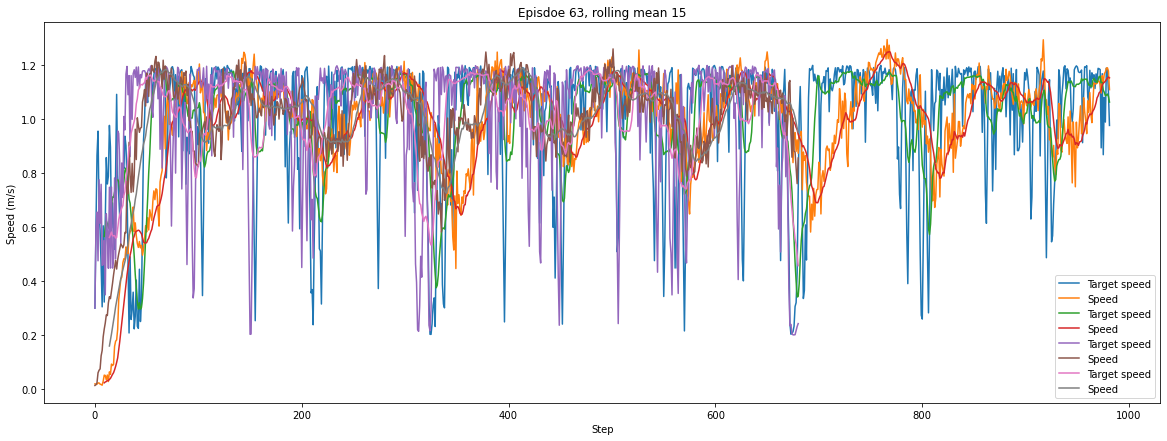

In [19]:
data = vs.load_data("../records/local_control/sac_figure_8_speed.csv")
e_63 = data[(data.Episode == 24) & (data.Step > 20)]
e_25 = data[(data.Episode == 26) & (data.Step > 20)]

lag = 15

def plot_speed(e, lag, title):
    plt.figure(1, (20, 7))
    x = np.arange(len(e))
    plt.plot(x, e.TargetSpeed.rolling(lag).mean(), label="Target speed")
    #plt.plot(x, e.Throttle.rolling(lag).mean() * 4, label="Scaled throttle")
    plt.plot(x, e.Speed.rolling(lag).mean(), label="Speed")
    plt.xlabel("Step")
    plt.ylabel("Speed (m/s)")
    plt.legend()
    plt.title(title)
    #plt.show()

plot_speed(e_25, 1, "Episode 25, raw")
plot_speed(e_25, 10, "Episode 25, rolling mean 15")
plot_speed(e_63, 1, "Episode 63, raw")
plot_speed(e_63, 15, "Episdoe 63, rolling mean 15")

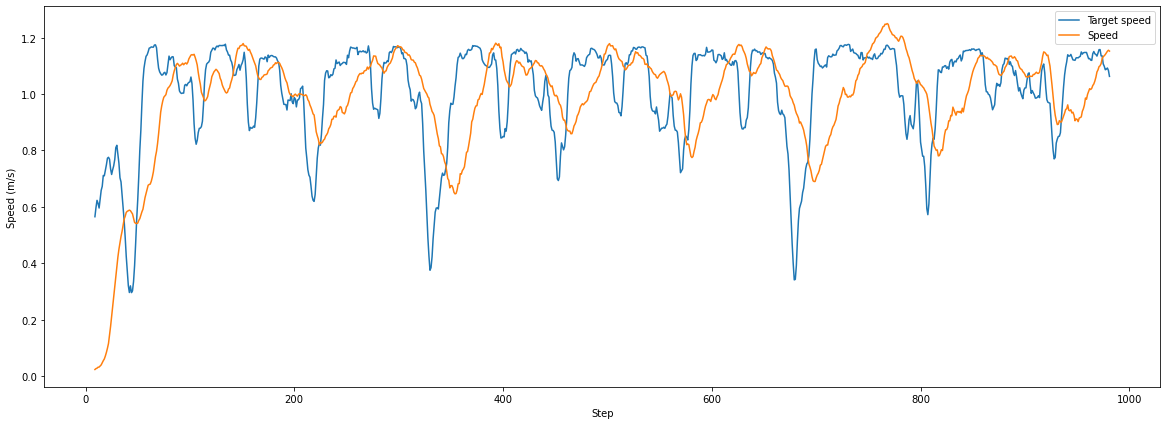

In [20]:
plot_speed(e_25, 10, "")
plt.savefig("./plots/Throttle.pdf")

KeyboardInterrupt: 

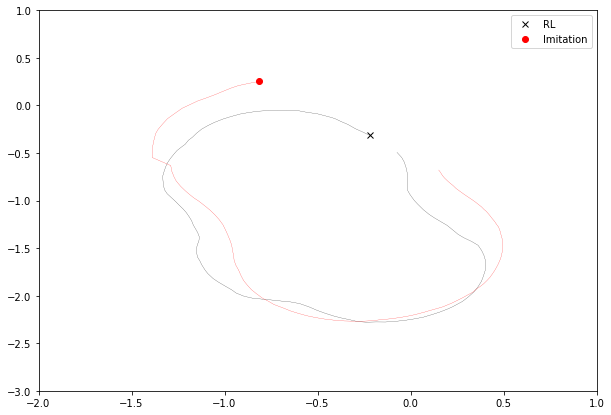

In [10]:
from IPython.display import clear_output

data = vs.load_data("../records/local_control/sac_figure_8_speed.csv")
mean_speed = data.groupby("Episode").mean().Speed[data.groupby("Episode").max().Step > 1000]

e_rl = data[(data.Episode == 26) & (data.Step > 170)]

data = vs.load_data("../records/local_control/imitation_record_2020-10-11T20:33:52.630958.csv")
mean_speed = data.groupby("Episode").mean().Speed[data.groupby("Episode").max().Step > 1000]

e_im = data[-1052:-200]

skip = 2
trail_width = 0.2
for step in range(1, len(e_rl), skip):
    clear_output(wait=True)
    step_rl = e_rl.iloc[:step]
    step_im = e_im.iloc[:step]
    plt.figure(1, (10, 7))
    plt.plot(step_rl.PosX, step_rl.PosZ, linewidth=trail_width, color="k")
    plt.plot(step_rl.PosX.values[-1], step_rl.PosZ.values[-1], marker="x", linestyle="None", color="k", label="RL")
    plt.plot(step_im.PosX, step_im.PosZ, linewidth=trail_width, color="r")
    plt.plot(step_im.PosX.values[-1], step_im.PosZ.values[-1], linestyle="None", marker="o", color="r", label="Imitation") 
    plt.ylim(-3, 1)
    plt.xlim(-2, 1)
    plt.legend()
    plt.savefig(f"./ims9/figure_{step:04d}.png", dpi=70)
    plt.show()

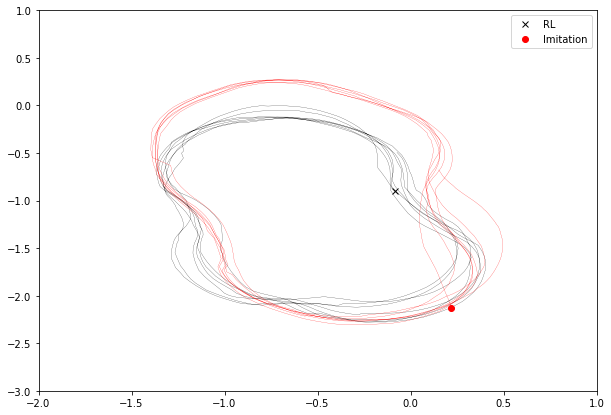

In [18]:
skip = 2
trail_width = 0.2
for step in range(1, len(e_rl), skip):
    clear_output(wait=True)
    step_rl = e_rl.iloc[:step]
    step_im = e_im.iloc[:step]
    plt.figure(1, (10, 7))
    plt.plot(step_rl.PosX, step_rl.PosZ, linewidth=trail_width, color="k")
    plt.plot(step_rl.PosX.values[-1], step_rl.PosZ.values[-1], marker="x", linestyle="None", color="k", label="RL")
    plt.plot(step_im.PosX, step_im.PosZ, linewidth=trail_width, color="r")
    plt.plot(step_im.PosX.values[-1], step_im.PosZ.values[-1], linestyle="None", marker="o", color="r", label="Imitation") 
    plt.ylim(-3, 1)
    plt.xlim(-2, 1)
    plt.legend()
    plt.savefig(f"./ims9/figure_{step:04d}.png", dpi=70)
    plt.show()

In [20]:
sorted_files = [x for x in sorted(os.listdir("./ims9")) if "png" in x]

In [21]:
for i, f in enumerate(sorted_files):
    os.rename(f"./ims9/{f}", f"./ims10/figure_{i:04d}.png")

In [22]:
!ffmpeg -f image2 -i ./ims10/figure_%04d.png -vcodec libx264 -crf 15  -pix_fmt yuv420p rl_vs_imitation_benchmark3.mp4

ffmpeg version 4.2.4-1ubuntu0.1 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.3.0-10ubuntu2)
  configuration: --prefix=/usr --extra-version=1ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-l

In [16]:
y


NameError: name 'y' is not defined